In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image
import os

In [ ]:
#Custom Dataset Definition
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, label, transform=None):
        self.folder_path = folder_path
        self.label = label
        self.transform = transform
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure image is RGB
        if self.transform:
            image = self.transform(image)
        return image, self.label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Dataset paths and labels
normal_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/NP"
abnormal_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/AH"
MI_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/MI"
history_MI_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/HMI"

normal_dataset = CustomDataset(normal_path, label=0, transform=transform)
abnormal_dataset = CustomDataset(abnormal_path, label=1, transform=transform)
MI_dataset = CustomDataset(MI_path, label=2, transform=transform)
history_MI_dataset = CustomDataset(history_MI_path, label=3, transform=transform)

# Combine datasets
combined_dataset = ConcatDataset([normal_dataset, abnormal_dataset, MI_dataset, history_MI_dataset])

# Split into training and validation datasets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_data, val_data = random_split(combined_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Load Pretrained VGG-16 Model
vgg16 = models.vgg16(pretrained=True)

# Modify the final layer for 4 classes
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 4)
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg16 = vgg16.to(device)

#  Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.3MB/s]


In [ ]:

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader.dataset))
        train_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / val_total)

        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    # Plot Results
    import matplotlib.pyplot as plt
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10 - Train Loss: 1.6181, Train Accuracy: 0.2776
Validation Loss: 1.7340, Validation Accuracy: 0.3387
Epoch 2/10 - Train Loss: 1.4313, Train Accuracy: 0.2695
Validation Loss: 1.3624, Validation Accuracy: 0.3387
Epoch 3/10 - Train Loss: 1.3998, Train Accuracy: 0.2520
Validation Loss: 1.4046, Validation Accuracy: 0.2634
Epoch 4/10 - Train Loss: 1.4090, Train Accuracy: 0.2695
Validation Loss: 1.3796, Validation Accuracy: 0.3387
Epoch 5/10 - Train Loss: 1.3857, Train Accuracy: 0.3019
Validation Loss: 1.3505, Validation Accuracy: 0.3387
Epoch 6/10 - Train Loss: 1.3579, Train Accuracy: 0.3140
Validation Loss: 1.1936, Validation Accuracy: 0.4946
Epoch 7/10 - Train Loss: 1.4363, Train Accuracy: 0.3275
Validation Loss: 1.3551, Validation Accuracy: 0.3387
Epoch 8/10 - Train Loss: 1.3910, Train Accuracy: 0.2992
Validation Loss: 1.3571, Validation Accuracy: 0.3387
Epoch 9/10 - Train Loss: 1.3821, Train Accuracy: 0.2736
Validation Loss: 1.3519, Validation Accuracy: 0.3387
Epoch 10/10 - Train

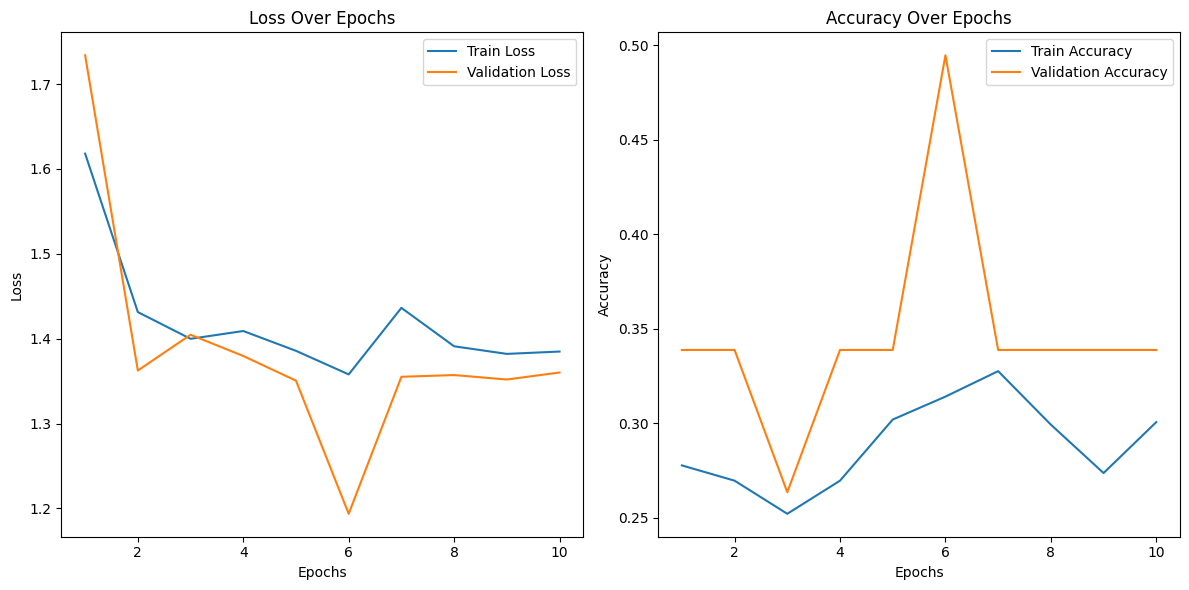

In [ ]:
train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)


In [ ]:
torch.save(vgg16.state_dict(), '/content/drive/MyDrive/SEM 5/Minor project/Online dataset/VGG16.pth')


In [4]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Example class names (modify as per your dataset)
class_names = ['Class 0', 'Class 1', 'Class 2']

# Assuming you already have the epoch-wise results like the predicted outputs and true labels.
# Replace this with your actual epoch predictions and true labels
predicted_labels = [0.277,0.2695,0.2520,0.2695,0.3019,0.3140,0.3275,0.2992,0.2736,0.3005]  # Example true labels for GoogleNet
true_labels= [0.3387,0.3387,0.2634,0.3387,0.3387,0.4946,0.3387,0.3387,0.3387,0.3387]  # Example predicted labels for GoogleNet
cm = confusion_matrix(true_labels, predicted_labels)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ValueError: continuous is not supported